#데이터 호출 

In [ ]:
!unzip /content/drive/MyDrive/DataSet/작물병해/data.zip

Archive:  /content/drive/MyDrive/DataSet/작물병해/data.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.csv               
  inflating: train.zip               


In [ ]:
!unzip train.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
   creating: train/55844/
  inflating: train/55844/55844.jpg   
  inflating: train/55844/55844.json  
  inflating: train/55844/55844.csv   
   creating: train/55847/
  inflating: train/55847/55847.jpg   
  inflating: train/55847/55847.csv   
  inflating: train/55847/55847.json  
   creating: train/55848/
  inflating: train/55848/55848.json  
  inflating: train/55848/55848.csv   
  inflating: train/55848/55848.jpg   
   creating: train/55858/
  inflating: train/55858/55858.json  
  inflating: train/55858/55858.jpg   
  inflating: train/55858/55858.csv   
   creating: train/55870/
  inflating: train/55870/55870.json  
  inflating: train/55870/55870.csv   
  inflating: train/55870/55870.jpg   
   creating: train/55889/
  inflating: train/55889/55889.jpg   
  inflating: train/55889/55889.csv   
  inflating: train/55889/55889.json  
   creating: train/55895/
  inflating: train/55895/55895.jpg   
  inflating: train/55895/55895.csv   
  inflating: train/558

# 모듈 임포트

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os
import cv2 
from glob import glob
from tqdm import tqdm
import json

# 데이터 호출

## 디렉토리 로드

In [ ]:
train_csv = sorted(glob('train/*/*.csv'))
train_jpg = sorted(glob('train/*/*.jpg'))
train_json = sorted(glob('train/*/*.json'))

## json 파일 로드

In [ ]:
crops = []
diseases = []
risks = []
labels = []

for i in range(len(train_json)):
    with open(train_json[i], 'r') as f:
        sample = json.load(f)
        crop = sample['annotations']['crop']
        disease = sample['annotations']['disease']
        risk = sample['annotations']['risk']
        label=f"{crop}_{disease}_{risk}"
    
        crops.append(crop)
        diseases.append(disease)
        risks.append(risk)
        labels.append(label)
        
label_unique = sorted(np.unique(labels))
label_unique = {key:value for key,value in zip(label_unique, range(len(label_unique)))}

labels = [label_unique[k] for k in labels]

In [ ]:
json = pd.DataFrame([crops,diseases,risks,labels]).T
json.columns = ['crop','disease','risk','label']

In [ ]:
json.head()

,crop,disease,risk,label
0,3,b7,1,9
1,3,00,0,3
2,3,00,0,3
3,3,00,0,3
4,3,00,0,3


### diseases 정제

In [ ]:
disease_unique = sorted(np.unique(diseases))
disease_unique = {key:value for key,value in zip(disease_unique, range(len(disease_unique)))}

In [ ]:
diseases = [disease_unique[k] for k in diseases]

(array([3996.,   42.,  189.,   99.,  307.,  166.,   32.,   21.,  290.,
         625.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <a list of 10 Patch objects>)

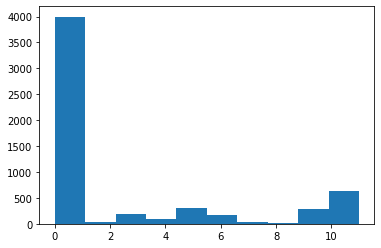

In [ ]:
plt.hist(diseases)

## 이미지 로드 

In [ ]:
def img_load(path):
    img = cv2.imread(path)[:,:,::-1]
    img = cv2.resize(img, (224, 224))
    return img

imgs = [img_load(k) for k in tqdm(train_jpg)]

100%|██████████| 5767/5767 [00:38<00:00, 148.47it/s]


## csv 로드 
- csv 파일들을 모두 불러올 방법 
- 특정 컬럼만 추출 
- 10분 단위로 두개 씩 있는데 이걸 하나로 합칠 방법 
- 우선은 CO2를 제외한 나머지 만을 이용 해 LSTM 모델 진행
  - 현재는 전체 데이터, 특정 컬럼만 모으는데 집중 

In [ ]:
# csv_features = ['측정시각','내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
#                 '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저','내부 CO2 평균', '내부 CO2 최저','내부 CO2 최고']

In [ ]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

In [ ]:
temp = train_csv[0]

In [ ]:
a = pd.read_csv(temp)

In [ ]:
b = np.array(a[csv_features])

In [ ]:
np.array([b,b]).shape

(2, 588, 9)

In [ ]:
def csv_load(path):
    csv = pd.read_csv(path)
    np_csv = np.array(a[csv_features])
    return np_csv

csvs = [csv_load(k) for k in tqdm(train_csv)]

100%|██████████| 5767/5767 [00:49<00:00, 115.47it/s]


In [ ]:
csvs = np.array(csvs)

In [ ]:
csvs.shape

(5767, 588, 9)

# 전처리 

In [ ]:
labels = np.array(labels)
imgs = np.array(imgs)
crops = np.array(crops)
diseases = np.array(diseases)

# Phase 1 
- 이미지만을 이용 해 crop classfication 
- resnet, efficient net만 이용 해서 image classification 

## 데이터 분할

In [ ]:
crops[crops==1]=0
crops[crops==2]=1
crops[crops==3]=2
crops[crops==4]=3
crops[crops==5]=4
crops[crops==6]=5

In [ ]:
set(crops)

{0, 1, 2, 3, 4, 5}

In [ ]:
from sklearn.model_selection import train_test_split 
train_x, test_x, train_y, test_y = train_test_split(imgs,crops)

In [ ]:
print(train_x.shape)

(4325, 224, 224, 3)


## 콜백


In [ ]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
# loss 실시간 출력 
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.logs = []
    self.fig = plt.figure()


  def on_epoch_end(self, epoch, logs={}):

    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])

#call backs 선언
plot_losses = PlotLosses()

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링 대상, 이걸 기준으로 멈춤 
    verbose=1,
    patience=50)         # 중지까지의 여유분


callbacks = [plot_losses,early_stopping]

## 모델

In [ ]:
# import the necessary packages
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.applications import resnet50, efficientnet
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

In [ ]:
# conv_layers = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# conv_layers.trainable = False

conv_layers = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

In [ ]:
image_input = Input((224,224,3))
x = conv_layers(image_input)
x = Flatten()(x)
x = Dense(10, activation = 'relu')(x)
x = Dense(10, activation = 'relu')(x)
output = Dense(6,activation = 'softmax')(x)
model_crop = Model(image_input,output)

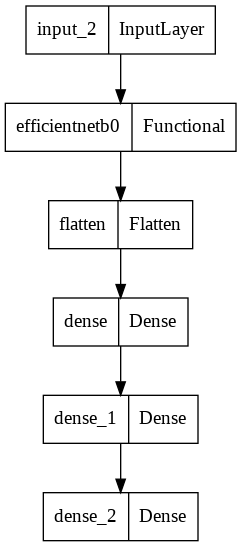

In [ ]:
#모델 설계 구조 
import tensorflow 
tensorflow.keras.utils.plot_model(model_crop)

In [ ]:
#학습 방식은 동일 
model_crop.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics = ['accuracy'])
model_crop.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 flatten_2 (Flatten)         (None, 62720)             0         
                                                                 
 dense_9 (Dense)             (None, 10)                627210    
                                                                 
 dense_10 (Dense)            (None, 10)                110       
                                                                 
 dense_11 (Dense)            (None, 6)                 66        
                                                                 
Total params: 4,676,957
Trainable params: 627,386
Non-train

전처리 안한 것 

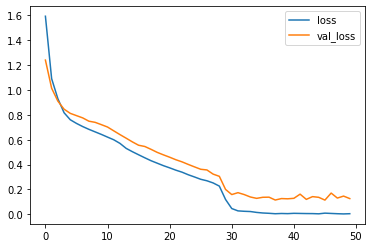

loss =  0.005019752774387598 , val_loss =  0.1266411542892456
14/14 [==============================] - 4s 310ms/step - loss: 0.0050 - accuracy: 0.9988 - val_loss: 0.1266 - val_accuracy: 0.9665


In [ ]:
history = model_crop.fit(train_x,train_y, epochs=50, verbose=1, batch_size=256, validation_split=0.2,callbacks=callbacks)

## 예측

In [ ]:
y_ = model_crop.predict(test_x)
predicted = np.argmax(y_,axis=1)
error = test_y - predicted
print(len(error[error==0])/len(error))

0.9687933425797504


# Phase 2 

##데이터 확인

이미지

In [ ]:
imgs.shape

(5767, 224, 224, 3)

Env 

In [ ]:
csvs.shape

(5767, 588, 9)

Crop

In [ ]:
crops.shape

(5767,)

disease

In [ ]:
diseases.shape

(5767,)

## 데이터 분할

In [ ]:
index = int(5767*0.8)
train_imgs = imgs[:index,:]
test_imgs = imgs[index:,:]

train_crops = crops[:index]
test_crops = crops[index:]

train_diseases = diseases[:index]
test_diseases = diseases[index:]

train_envs = csvs[:index,:,:]
test_envs = csvs[index:,:,:]

In [ ]:
print(train_imgs.shape,train_crops.shape,train_diseases.shape,train_envs.shape)

(4613, 224, 224, 3) (4613,) (4613,) (4613, 588, 9)


## 모델

In [ ]:
# import the necessary packages
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.applications import resnet50, efficientnet
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

In [ ]:
conv_layers = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

In [ ]:
#Env 데이터 파트 
Env_input = Input((588,9)) #<---- shape 
x = Bidrection(LSTM(128))(Env_input) #bidirec
x = Flatten()(x)
x = Dense(10, activation ='relu')(x)
Env_output = Dense(10 ,activation='linear')(x)

#iamge 데이터 파트 
image_input = Input((224,224,3))
x = conv_layers(image_input)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
image_output = Dense(10, activation='linear')(x)

#crop 데이터 파트 
crop_input = Input(1) #<---- 
x = Dense(32, activation = 'relu')(crop_input)
# x = Dense(32, activation = 'relu')(x)
crop_output = Dense(10, activation = 'linear')(x) #<-- linear 

#헤드 결합 
combined_input = concatenate([Env_output,image_output,crop_output])
x= Dense(32, activation = 'relu')(combined_input) #<--- Dense 
output = Dense(12,activation = 'softmax')(x)

combined_model = Model([Env_input,image_input,crop_input],output)

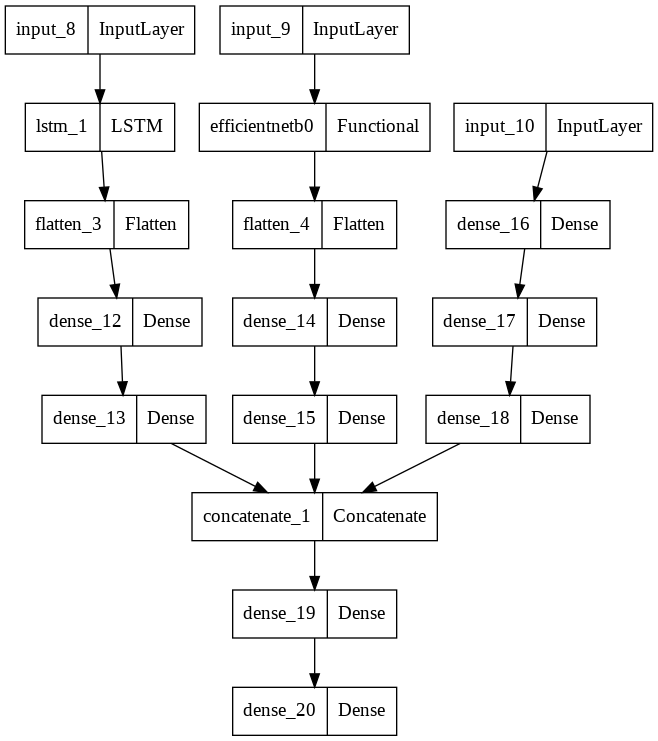

In [ ]:
#모델 설계 구조 
import tensorflow 
tensorflow.keras.utils.plot_model(combined_model)

In [ ]:
#학습 방식은 동일 
combined_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics = ['accuracy'])
combined_model.summary() #optimizer tuning

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 588, 9)]     0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 lstm_1 (LSTM)                  (None, 128)          70656       ['input_8[0][0]']                
                                                                                                  
 efficientnetb0 (Functional)    (None, 7, 7, 1280)   4049571     ['input_9[0][0]']          

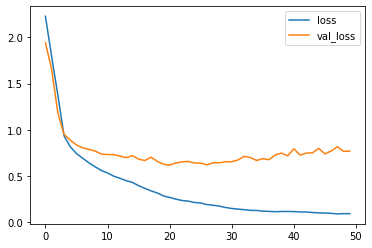

loss =  0.08957906067371368 , val_loss =  0.7685027718544006
15/15 [==============================] - 5s 358ms/step - loss: 0.0896 - accuracy: 0.9772 - val_loss: 0.7685 - val_accuracy: 0.8787


In [ ]:
history = combined_model.fit([train_envs,train_imgs,train_crops],train_diseases, epochs=50, verbose=1, batch_size=256, validation_split=0.2,callbacks=callbacks)

## 예측

In [ ]:
y_ = combined_model.predict([test_envs,test_imgs,test_crops])
predicted = np.argmax(y_,axis=1)
error = test_diseases - predicted
print(len(error[error==0])/len(error))

0.8639514731369151


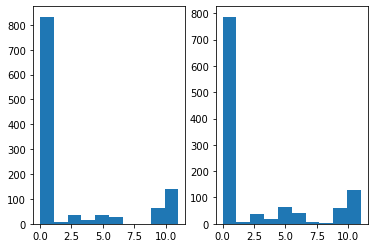

In [ ]:
plt.subplot(1,2,1)
plt.hist(predicted)

plt.subplot(1,2,2)
plt.hist(test_diseases)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_diseases, predicted)
print(cm)

[[764   1   2   0   0   0   0   0   0   4   0   2]
 [  0  11   1   2   0   0   0   0   0   0   0   0]
 [  3   0   4   0   0   0   0   0   0   0   0   0]
 [  5   0   0  32   0   0   0   0   0   0   0   0]
 [  0   4   0   0  14   0   1   0   0   0   0   1]
 [ 16   0   0   0   0  34   0   0   0   0   0  14]
 [  0   0   0   0   0   0  12   0   0   4  12  13]
 [  4   0   0   1   0   0   1   0   0   0   0   1]
 [  0   2   1   0   1   0   0   0   0   0   0   0]
 [ 13   0   0   0   0   0   1   0   0  39   0   7]
 [  3   0   0   0   0   0   9   0   0   2  45   2]
 [  7   0   0   0   0   2   2   0   0  13   0  42]]


In [ ]:
print(classification_report(test_diseases, predicted, target_names=['0','1','2','3','4','5','6','7','8','9','10','11']))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       773
           1       0.61      0.79      0.69        14
           2       0.50      0.57      0.53         7
           3       0.91      0.86      0.89        37
           4       0.93      0.70      0.80        20
           5       0.94      0.53      0.68        64
           6       0.46      0.29      0.36        41
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00         4
           9       0.63      0.65      0.64        60
          10       0.79      0.74      0.76        61
          11       0.51      0.64      0.57        66

    accuracy                           0.86      1154
   macro avg       0.60      0.56      0.57      1154
weighted avg       0.86      0.86      0.85      1154



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Phase 4 test

In [ ]:
y_ = model_crop.predict(test_imgs)

In [ ]:
predicted_crop = np.argmax(y_,axis=1)

In [ ]:
y_ = combined_model.predict([test_envs,test_imgs,test_crops])

In [ ]:
predicted_diseases = np.argmax(y_,axis=1)

In [ ]:
temp = json[4613:]

In [ ]:
temp['predicted_crop'] = predicted_crop

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
temp['predicted_diseases'] = predicted_diseases

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
temp['predicted_crop'] = temp['predicted_crop'].apply(lambda x:x+1) #crop 1~6을 0~5로 바꿧던거 원복 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
temp

,crop,disease,risk,label,predicted_crop,predicted_diseases,disease_code
4613,6,b4,1,22,6,0,7
4614,3,00,0,3,3,0,0
4615,5,b7,1,15,5,10,10
4616,2,a5,2,2,2,0,3
4617,3,00,0,3,3,0,0
...,...,...,...,...,...,...,...
5762,3,00,0,3,3,0,0
5763,1,00,0,0,1,0,0
5764,2,a5,2,2,2,3,3
5765,1,00,0,0,1,0,0


In [ ]:
temp['disease_code'] =temp['disease'].apply(lambda x:disease_unique[x]) #질병 코드를 disease_unqiue 이용 해서 cat code로 변경 

In [ ]:
temp = np.array(temp['predicted_diseases']) - np.array(temp['disease_code']) 

In [ ]:
len(temp[temp==0])/len(temp)

0.8639514731369151

# 번외 - Direct Label Predict

In [ ]:
labels.shape

(5767,)

In [ ]:
index = int(5767*0.8)
train_imgs = imgs[:index,:]
test_imgs = imgs[index:,:]

train_crops = crops[:index]
test_crops = crops[index:]

train_diseases = diseases[:index]
test_diseases = diseases[index:]

train_envs = csvs[:index,:,:]
test_envs = csvs[index:,:,:]

train_labels = labels[:index]
test_labels = labels[index:]

In [ ]:
#Env 데이터 파트 
Env_input = Input((588,9)) #<---- shape 
x = LSTM(128)(Env_input)
x = Flatten()(x)
x = Dense(10, activation ='relu')(x)
Env_output = Dense(10 ,activation='linear')(x)

#iamge 데이터 파트 
image_input = Input((224,224,3))
x = conv_layers(image_input)
x = Flatten()(x)
x = Dense(10, activation='relu')(x)
image_output = Dense(10, activation='linear')(x)


#헤드 결합 
combined_input = concatenate([Env_output,image_output])
x= Dense(4, activation = 'relu')(combined_input) #<--- Dense 
output = Dense(25,activation = 'softmax')(x)

label_model = Model([Env_input,image_input],output)

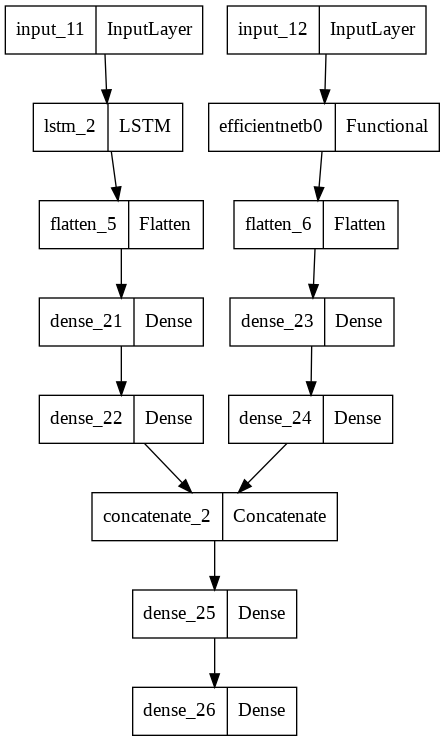

In [ ]:
#모델 설계 구조 
import tensorflow 
tensorflow.keras.utils.plot_model(label_model)

In [ ]:
#학습 방식은 동일 
label_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics = ['accuracy'])
label_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 588, 9)]     0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 lstm_2 (LSTM)                  (None, 128)          70656       ['input_11[0][0]']               
                                                                                                  
 efficientnetb0 (Functional)    (None, 7, 7, 1280)   4049571     ['input_12[0][0]']         

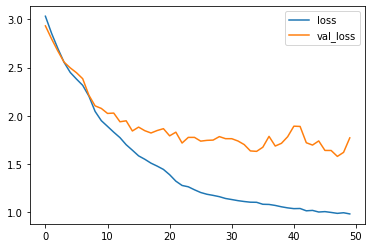

loss =  0.9807466268539429 , val_loss =  1.7702832221984863
15/15 [==============================] - 5s 358ms/step - loss: 0.9807 - accuracy: 0.8247 - val_loss: 1.7703 - val_accuracy: 0.7530


In [ ]:
history = label_model.fit([train_envs,train_imgs],train_labels, epochs=50, verbose=1, batch_size=256, validation_split=0.2,callbacks=callbacks)

#데이터 호출 

In [ ]:
!unzip /content/drive/MyDrive/DataSet/작물병해/data.zip

Archive:  /content/drive/MyDrive/DataSet/작물병해/data.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.csv               
  inflating: train.zip               


In [ ]:
!unzip train.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
   creating: train/55844/
  inflating: train/55844/55844.jpg   
  inflating: train/55844/55844.json  
  inflating: train/55844/55844.csv   
   creating: train/55847/
  inflating: train/55847/55847.jpg   
  inflating: train/55847/55847.csv   
  inflating: train/55847/55847.json  
   creating: train/55848/
  inflating: train/55848/55848.json  
  inflating: train/55848/55848.csv   
  inflating: train/55848/55848.jpg   
   creating: train/55858/
  inflating: train/55858/55858.json  
  inflating: train/55858/55858.jpg   
  inflating: train/55858/55858.csv   
   creating: train/55870/
  inflating: train/55870/55870.json  
  inflating: train/55870/55870.csv   
  inflating: train/55870/55870.jpg   
   creating: train/55889/
  inflating: train/55889/55889.jpg   
  inflating: train/55889/55889.csv   
  inflating: train/55889/55889.json  
   creating: train/55895/
  inflating: train/55895/55895.jpg   
  inflating: train/55895/55895.csv   
  inflating: train/558

# 모듈 임포트

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os
import cv2 
from glob import glob
from tqdm import tqdm
import json

# 데이터 호출

## 디렉토리 로드

In [ ]:
train_csv = sorted(glob('train/*/*.csv'))
train_jpg = sorted(glob('train/*/*.jpg'))
train_json = sorted(glob('train/*/*.json'))

## json 파일 로드

In [ ]:
crops = []
diseases = []
risks = []
labels = []

for i in range(len(train_json)):
    with open(train_json[i], 'r') as f:
        sample = json.load(f)
        crop = sample['annotations']['crop']
        disease = sample['annotations']['disease']
        risk = sample['annotations']['risk']
        label=f"{crop}_{disease}_{risk}"
    
        crops.append(crop)
        diseases.append(disease)
        risks.append(risk)
        labels.append(label)
        
label_unique = sorted(np.unique(labels))
label_unique = {key:value for key,value in zip(label_unique, range(len(label_unique)))}

labels = [label_unique[k] for k in labels]

In [ ]:
json = pd.DataFrame([crops,diseases,risks,labels]).T
json.columns = ['crop','disease','risk','label']

In [ ]:
json.head()

,crop,disease,risk,label
0,3,b7,1,9
1,3,00,0,3
2,3,00,0,3
3,3,00,0,3
4,3,00,0,3


### diseases 정제

In [ ]:
disease_unique = sorted(np.unique(diseases))
disease_unique = {key:value for key,value in zip(disease_unique, range(len(disease_unique)))}

In [ ]:
diseases = [disease_unique[k] for k in diseases]

(array([3996.,   42.,  189.,   99.,  307.,  166.,   32.,   21.,  290.,
         625.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <a list of 10 Patch objects>)

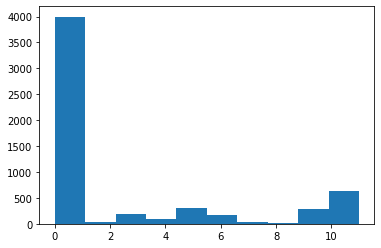

In [ ]:
plt.hist(diseases)

## 이미지 로드 

In [ ]:
def img_load(path):
    img = cv2.imread(path)[:,:,::-1]
    img = cv2.resize(img, (224, 224))
    return img

imgs = [img_load(k) for k in tqdm(train_jpg)]

100%|██████████| 5767/5767 [00:38<00:00, 148.47it/s]


## csv 로드 
- csv 파일들을 모두 불러올 방법 
- 특정 컬럼만 추출 
- 10분 단위로 두개 씩 있는데 이걸 하나로 합칠 방법 
- 우선은 CO2를 제외한 나머지 만을 이용 해 LSTM 모델 진행
  - 현재는 전체 데이터, 특정 컬럼만 모으는데 집중 

In [ ]:
# csv_features = ['측정시각','내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
#                 '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저','내부 CO2 평균', '내부 CO2 최저','내부 CO2 최고']

In [ ]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

In [ ]:
temp = train_csv[0]

In [ ]:
a = pd.read_csv(temp)

In [ ]:
b = np.array(a[csv_features])

In [ ]:
np.array([b,b]).shape

(2, 588, 9)

In [ ]:
def csv_load(path):
    csv = pd.read_csv(path)
    np_csv = np.array(a[csv_features])
    return np_csv

csvs = [csv_load(k) for k in tqdm(train_csv)]

100%|██████████| 5767/5767 [00:49<00:00, 115.47it/s]


In [ ]:
csvs = np.array(csvs)

In [ ]:
csvs.shape

(5767, 588, 9)

# 전처리 

In [ ]:
labels = np.array(labels)
imgs = np.array(imgs)
crops = np.array(crops)
diseases = np.array(diseases)

# Phase 1 
- 이미지만을 이용 해 crop classfication 
- resnet, efficient net만 이용 해서 image classification 

## 데이터 분할

In [ ]:
crops[crops==1]=0
crops[crops==2]=1
crops[crops==3]=2
crops[crops==4]=3
crops[crops==5]=4
crops[crops==6]=5

In [ ]:
set(crops)

{0, 1, 2, 3, 4, 5}

In [ ]:
from sklearn.model_selection import train_test_split 
train_x, test_x, train_y, test_y = train_test_split(imgs,crops)

In [ ]:
print(train_x.shape)

(4325, 224, 224, 3)


## 콜백


In [ ]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
# loss 실시간 출력 
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.logs = []
    self.fig = plt.figure()


  def on_epoch_end(self, epoch, logs={}):

    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])

#call backs 선언
plot_losses = PlotLosses()

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링 대상, 이걸 기준으로 멈춤 
    verbose=1,
    patience=50)         # 중지까지의 여유분


callbacks = [plot_losses,early_stopping]

## 모델

In [ ]:
# import the necessary packages
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.applications import resnet50, efficientnet
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

In [ ]:
# conv_layers = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# conv_layers.trainable = False

conv_layers = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

In [ ]:
image_input = Input((224,224,3))
x = conv_layers(image_input)
x = Flatten()(x)
x = Dense(10, activation = 'relu')(x)
x = Dense(10, activation = 'relu')(x)
output = Dense(6,activation = 'softmax')(x)
model_crop = Model(image_input,output)

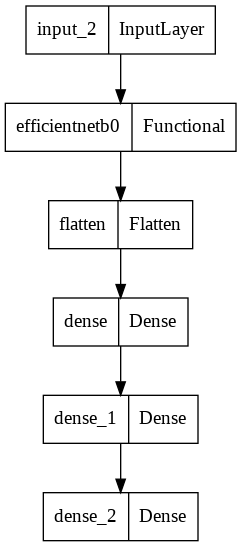

In [ ]:
#모델 설계 구조 
import tensorflow 
tensorflow.keras.utils.plot_model(model_crop)

In [ ]:
#학습 방식은 동일 
model_crop.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics = ['accuracy'])
model_crop.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 flatten_2 (Flatten)         (None, 62720)             0         
                                                                 
 dense_9 (Dense)             (None, 10)                627210    
                                                                 
 dense_10 (Dense)            (None, 10)                110       
                                                                 
 dense_11 (Dense)            (None, 6)                 66        
                                                                 
Total params: 4,676,957
Trainable params: 627,386
Non-train

전처리 안한 것 

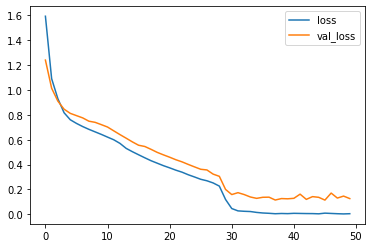

loss =  0.005019752774387598 , val_loss =  0.1266411542892456
14/14 [==============================] - 4s 310ms/step - loss: 0.0050 - accuracy: 0.9988 - val_loss: 0.1266 - val_accuracy: 0.9665


In [ ]:
history = model_crop.fit(train_x,train_y, epochs=50, verbose=1, batch_size=256, validation_split=0.2,callbacks=callbacks)

## 예측

In [ ]:
y_ = model_crop.predict(test_x)
predicted = np.argmax(y_,axis=1)
error = test_y - predicted
print(len(error[error==0])/len(error))

0.9687933425797504


# Phase 2 

##데이터 확인

이미지

In [ ]:
imgs.shape

(5767, 224, 224, 3)

Env 

In [ ]:
csvs.shape

(5767, 588, 9)

Crop

In [ ]:
crops.shape

(5767,)

disease

In [ ]:
diseases.shape

(5767,)

## 데이터 분할

In [ ]:
index = int(5767*0.8)
train_imgs = imgs[:index,:]
test_imgs = imgs[index:,:]

train_crops = crops[:index]
test_crops = crops[index:]

train_diseases = diseases[:index]
test_diseases = diseases[index:]

train_envs = csvs[:index,:,:]
test_envs = csvs[index:,:,:]

In [ ]:
print(train_imgs.shape,train_crops.shape,train_diseases.shape,train_envs.shape)

(4613, 224, 224, 3) (4613,) (4613,) (4613, 588, 9)


## 모델

In [ ]:
# import the necessary packages
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.applications import resnet50, efficientnet
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

In [ ]:
conv_layers = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

In [ ]:
#Env 데이터 파트 
Env_input = Input((588,9)) #<---- shape 
x = Bidrection(LSTM(128))(Env_input) #bidirec
x = Flatten()(x)
x = Dense(10, activation ='relu')(x)
Env_output = Dense(10 ,activation='linear')(x)

#iamge 데이터 파트 
image_input = Input((224,224,3))
x = conv_layers(image_input)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
image_output = Dense(10, activation='linear')(x)

#crop 데이터 파트 
crop_input = Input(1) #<---- 
x = Dense(32, activation = 'relu')(crop_input)
# x = Dense(32, activation = 'relu')(x)
crop_output = Dense(10, activation = 'linear')(x) #<-- linear 

#헤드 결합 
combined_input = concatenate([Env_output,image_output,crop_output])
x= Dense(32, activation = 'relu')(combined_input) #<--- Dense 
output = Dense(12,activation = 'softmax')(x)

combined_model = Model([Env_input,image_input,crop_input],output)

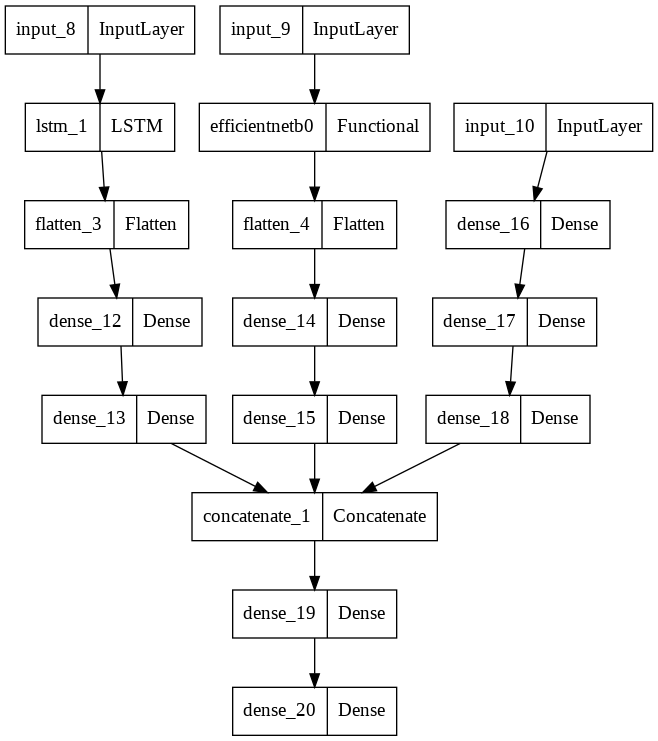

In [ ]:
#모델 설계 구조 
import tensorflow 
tensorflow.keras.utils.plot_model(combined_model)

In [ ]:
#학습 방식은 동일 
combined_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics = ['accuracy'])
combined_model.summary() #optimizer tuning

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 588, 9)]     0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 lstm_1 (LSTM)                  (None, 128)          70656       ['input_8[0][0]']                
                                                                                                  
 efficientnetb0 (Functional)    (None, 7, 7, 1280)   4049571     ['input_9[0][0]']          

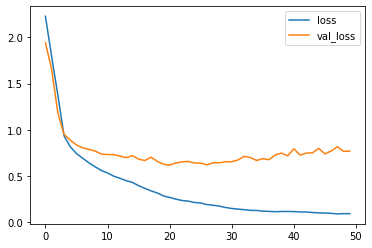

loss =  0.08957906067371368 , val_loss =  0.7685027718544006
15/15 [==============================] - 5s 358ms/step - loss: 0.0896 - accuracy: 0.9772 - val_loss: 0.7685 - val_accuracy: 0.8787


In [ ]:
history = combined_model.fit([train_envs,train_imgs,train_crops],train_diseases, epochs=50, verbose=1, batch_size=256, validation_split=0.2,callbacks=callbacks)

## 예측

In [ ]:
y_ = combined_model.predict([test_envs,test_imgs,test_crops])
predicted = np.argmax(y_,axis=1)
error = test_diseases - predicted
print(len(error[error==0])/len(error))

0.8639514731369151


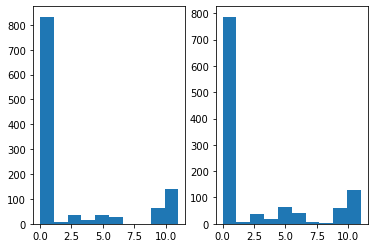

In [ ]:
plt.subplot(1,2,1)
plt.hist(predicted)

plt.subplot(1,2,2)
plt.hist(test_diseases)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_diseases, predicted)
print(cm)

[[764   1   2   0   0   0   0   0   0   4   0   2]
 [  0  11   1   2   0   0   0   0   0   0   0   0]
 [  3   0   4   0   0   0   0   0   0   0   0   0]
 [  5   0   0  32   0   0   0   0   0   0   0   0]
 [  0   4   0   0  14   0   1   0   0   0   0   1]
 [ 16   0   0   0   0  34   0   0   0   0   0  14]
 [  0   0   0   0   0   0  12   0   0   4  12  13]
 [  4   0   0   1   0   0   1   0   0   0   0   1]
 [  0   2   1   0   1   0   0   0   0   0   0   0]
 [ 13   0   0   0   0   0   1   0   0  39   0   7]
 [  3   0   0   0   0   0   9   0   0   2  45   2]
 [  7   0   0   0   0   2   2   0   0  13   0  42]]


In [ ]:
print(classification_report(test_diseases, predicted, target_names=['0','1','2','3','4','5','6','7','8','9','10','11']))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       773
           1       0.61      0.79      0.69        14
           2       0.50      0.57      0.53         7
           3       0.91      0.86      0.89        37
           4       0.93      0.70      0.80        20
           5       0.94      0.53      0.68        64
           6       0.46      0.29      0.36        41
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00         4
           9       0.63      0.65      0.64        60
          10       0.79      0.74      0.76        61
          11       0.51      0.64      0.57        66

    accuracy                           0.86      1154
   macro avg       0.60      0.56      0.57      1154
weighted avg       0.86      0.86      0.85      1154



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Phase 4 test

In [ ]:
y_ = model_crop.predict(test_imgs)

In [ ]:
predicted_crop = np.argmax(y_,axis=1)

In [ ]:
y_ = combined_model.predict([test_envs,test_imgs,test_crops])

In [ ]:
predicted_diseases = np.argmax(y_,axis=1)

In [ ]:
temp = json[4613:]

In [ ]:
temp['predicted_crop'] = predicted_crop

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
temp['predicted_diseases'] = predicted_diseases

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
temp['predicted_crop'] = temp['predicted_crop'].apply(lambda x:x+1) #crop 1~6을 0~5로 바꿧던거 원복 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
temp

,crop,disease,risk,label,predicted_crop,predicted_diseases,disease_code
4613,6,b4,1,22,6,0,7
4614,3,00,0,3,3,0,0
4615,5,b7,1,15,5,10,10
4616,2,a5,2,2,2,0,3
4617,3,00,0,3,3,0,0
...,...,...,...,...,...,...,...
5762,3,00,0,3,3,0,0
5763,1,00,0,0,1,0,0
5764,2,a5,2,2,2,3,3
5765,1,00,0,0,1,0,0


In [ ]:
temp['disease_code'] =temp['disease'].apply(lambda x:disease_unique[x]) #질병 코드를 disease_unqiue 이용 해서 cat code로 변경 

In [ ]:
temp = np.array(temp['predicted_diseases']) - np.array(temp['disease_code']) 

In [ ]:
len(temp[temp==0])/len(temp)

0.8639514731369151

# 번외 - Direct Label Predict

In [ ]:
labels.shape

(5767,)

In [ ]:
index = int(5767*0.8)
train_imgs = imgs[:index,:]
test_imgs = imgs[index:,:]

train_crops = crops[:index]
test_crops = crops[index:]

train_diseases = diseases[:index]
test_diseases = diseases[index:]

train_envs = csvs[:index,:,:]
test_envs = csvs[index:,:,:]

train_labels = labels[:index]
test_labels = labels[index:]

In [ ]:
#Env 데이터 파트 
Env_input = Input((588,9)) #<---- shape 
x = LSTM(128)(Env_input)
x = Flatten()(x)
x = Dense(10, activation ='relu')(x)
Env_output = Dense(10 ,activation='linear')(x)

#iamge 데이터 파트 
image_input = Input((224,224,3))
x = conv_layers(image_input)
x = Flatten()(x)
x = Dense(10, activation='relu')(x)
image_output = Dense(10, activation='linear')(x)


#헤드 결합 
combined_input = concatenate([Env_output,image_output])
x= Dense(4, activation = 'relu')(combined_input) #<--- Dense 
output = Dense(25,activation = 'softmax')(x)

label_model = Model([Env_input,image_input],output)

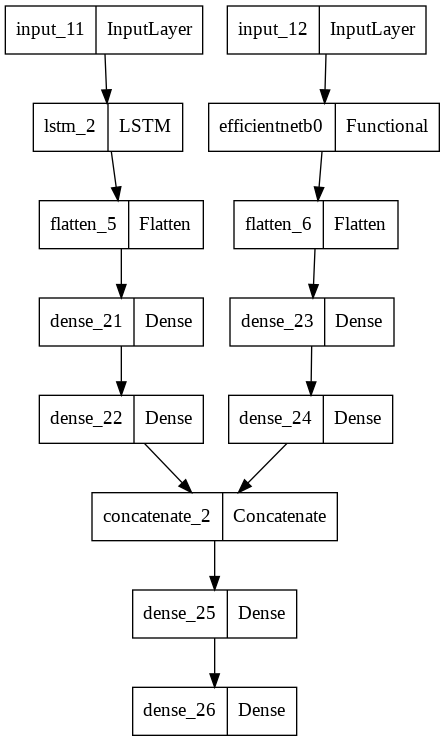

In [ ]:
#모델 설계 구조 
import tensorflow 
tensorflow.keras.utils.plot_model(label_model)

In [ ]:
#학습 방식은 동일 
label_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics = ['accuracy'])
label_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 588, 9)]     0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 lstm_2 (LSTM)                  (None, 128)          70656       ['input_11[0][0]']               
                                                                                                  
 efficientnetb0 (Functional)    (None, 7, 7, 1280)   4049571     ['input_12[0][0]']         

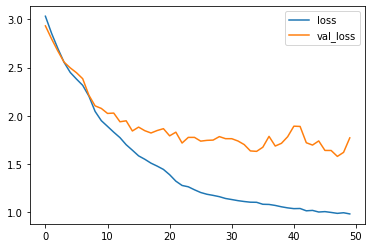

loss =  0.9807466268539429 , val_loss =  1.7702832221984863
15/15 [==============================] - 5s 358ms/step - loss: 0.9807 - accuracy: 0.8247 - val_loss: 1.7703 - val_accuracy: 0.7530


In [ ]:
history = label_model.fit([train_envs,train_imgs],train_labels, epochs=50, verbose=1, batch_size=256, validation_split=0.2,callbacks=callbacks)